# Passing map analysis

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch

In [2]:
# read data
df = pd.read_csv('../data/processed_timelines.csv')

In [3]:
# init positional variables list
pos_vars = ['start_position_x', 'end_position_x', 'start_position_y', 'end_position_y']

In [4]:
# create a mask for international and Finnish events separately, and home and away respectively
dom_mask = df.int_level == 0
int_mask = df.int_level == 1
home_mask = df.team == 'Home'
away_mask = df.team == 'Away'
home_goal_kick_mask = (df.team == 'Home') & (df.event_type == 'Pass') & (df.start_position_x > -55) & (df.start_position_x < -40) & (df.start_position_y > -10) & (df.start_position_y < 10)
away_goal_kick_mask = (df.team == 'Away') & (df.event_type == 'Pass') & (df.start_position_x < 55) & (df.start_position_x > 40) & (df.start_position_y > -10) & (df.start_position_y < 10)
kick_off_mask = (df.event_type == 'Pass') & (df.start_position_x > -1.5) & (df.start_position_x < 1.5) & (df.start_position_y > -1.5) & (df.start_position_y < 1.5)
within_5_yard_home = (df.team == 'Home') & (df.event_type == 'Pass') & (df.start_position_x < -42) & (df.start_position_y > -12) & (df.start_position_y < 12) & (df.end_position_x < -42) & (df.end_position_y > -12) & (df.end_position_y < 12)
within_5_yard_away = (df.team == 'Away') & (df.event_type == 'Pass') & (df.start_position_x > 42) & (df.start_position_y > -12) & (df.start_position_y < 12) & (df.end_position_x > 42) & (df.end_position_y > -12) & (df.end_position_y < 12)

In [5]:
# identify goalkeepers ids
##########################

gk_id_df = df.loc[df['event_type'] == 'GoalKick', ['match_id', 'team', 'player']]

most_freq_players = (
    gk_id_df.groupby(['match_id', 'team'])['player']
    .agg(lambda x: x.mode().iloc[0])  # mode().iloc[0] gets the most frequent value
    .reset_index()
)

# Step 2: Pivot the table so that 'Home' and 'Away' become columns
gk_id_df = most_freq_players.pivot(index='match_id', columns='team', values='player')

# Step 3: Rename the columns
gk_id_df = gk_id_df.rename(columns={'Home': 'home_gk_id', 'Away': 'away_gk_id'}).reset_index()

###################

# nan fills
most_freq_players_home = (
    df.loc[home_goal_kick_mask].groupby(['match_id', 'team'])['passer']
    .agg(lambda x: x.mode().iloc[0])  # mode().iloc[0] gets the most frequent value
    .reset_index()
)

# Step 2: Pivot the table so that 'Home' and 'Away' become columns
home_nan_fill = most_freq_players_home.pivot(index='match_id', columns='team', values='passer')


# Step 3: Rename the columns
home_nan_fill = home_nan_fill.rename(columns={'Home': 'home_gk_id_nan_fill'}).reset_index()

most_freq_players_away = (
    df.loc[away_goal_kick_mask].groupby(['match_id', 'team'])['passer']
    .agg(lambda x: x.mode().iloc[0])  # mode().iloc[0] gets the most frequent value
    .reset_index()
)

# Step 2: Pivot the table so that 'Home' and 'Away' become columns
away_nan_fill = most_freq_players_away.pivot(index='match_id', columns='team', values='passer')


# Step 3: Rename the columns
away_nan_fill = away_nan_fill.rename(columns={'Away': 'away_gk_id_nan_fill'}).reset_index()

##############

# merge the dataframes
gk_id_nan_fill = away_nan_fill.merge(home_nan_fill, on='match_id', how='left')
gk_id_df = gk_id_df.merge(gk_id_nan_fill, on='match_id', how='left')

# Fill NaNs in away_gk_id and home_gk_id using the nan_fill columns
gk_id_df['away_gk_id'] = gk_id_df['away_gk_id'].fillna(gk_id_df['away_gk_id_nan_fill'])
gk_id_df['home_gk_id'] = gk_id_df['home_gk_id'].fillna(gk_id_df['home_gk_id_nan_fill'])

# Drop the helper columns
gk_id_df = gk_id_df.drop(columns=['away_gk_id_nan_fill', 'home_gk_id_nan_fill'])

In [6]:
# remove all passes made by the goalkeepers
# Merge goalkeeper IDs to passes_df
merged_df = df.merge(gk_id_df, on='match_id', how='left')

# Determine the relevant goalkeeper ID for each row based on team
merged_df['gk_id_for_team'] = merged_df.apply(
    lambda row: row['home_gk_id'] if row['team'] == 'Home' else row['away_gk_id'],
    axis=1
)

# Filter out rows where the player is the goalkeeper of their own team
filtered_df = merged_df[merged_df['passer'] != merged_df['gk_id_for_team']]

# Drop helper columns if desired
filtered_df = filtered_df.drop(columns=['home_gk_id', 'away_gk_id', 'gk_id_for_team'])

df = filtered_df

In [7]:
# many teams take goalkicks by passing the ball to the goalkeeper by an outfield player, we can remove these goalkicks
# mislabeled as passes by removing passes that start and end in the 5-yard box
df = df.drop(df.loc[within_5_yard_home | within_5_yard_away].index, axis=0)

In [8]:
# remove passes which are most likely kick offs
df = df.loc[~(kick_off_mask)]

In [9]:
# match_home_mask = (df_passes.match_id == 3275) & (df_passes.team == 'Away') & (df_passes.period == 2)
# df_passes = df_passes.loc[match_home_mask, ['start_position_x', 'start_position_y', 'end_position_x', 'end_position_y', 'result']]

In [10]:
# ignore all other events than passes
df_passes = df[df['event_type'] == 'Pass']

In [11]:
# define basic pitch creation
def create_pitch(pad_top=0):

    # Customize the pitch
    pitch = Pitch(
        pitch_type='skillcorner', # Centered indexing
        pitch_length=100,
        pitch_width=63,
        pitch_color='#D0D0D0',  # Background color
        line_color='white',   # Line color
        axis=True,
        label=False,
        stripe=False,          # Add stripes to the pitch
        corner_arcs=True,     # Draw corner arcs
        goal_type='box',
        pad_top=pad_top,
        line_zorder=2
    )
    
    return pitch  

In [12]:
# pd.options.display.max_rows = 500
# df.loc[df['match_id'] == 1256, ['event_type', 'team', 'seconds_from_period_start', 'start_position_x', 'start_position_y', 'end_position_x', 'end_position_y']]

In [13]:
df = df[df['event_type'].isin(['Shot'])]

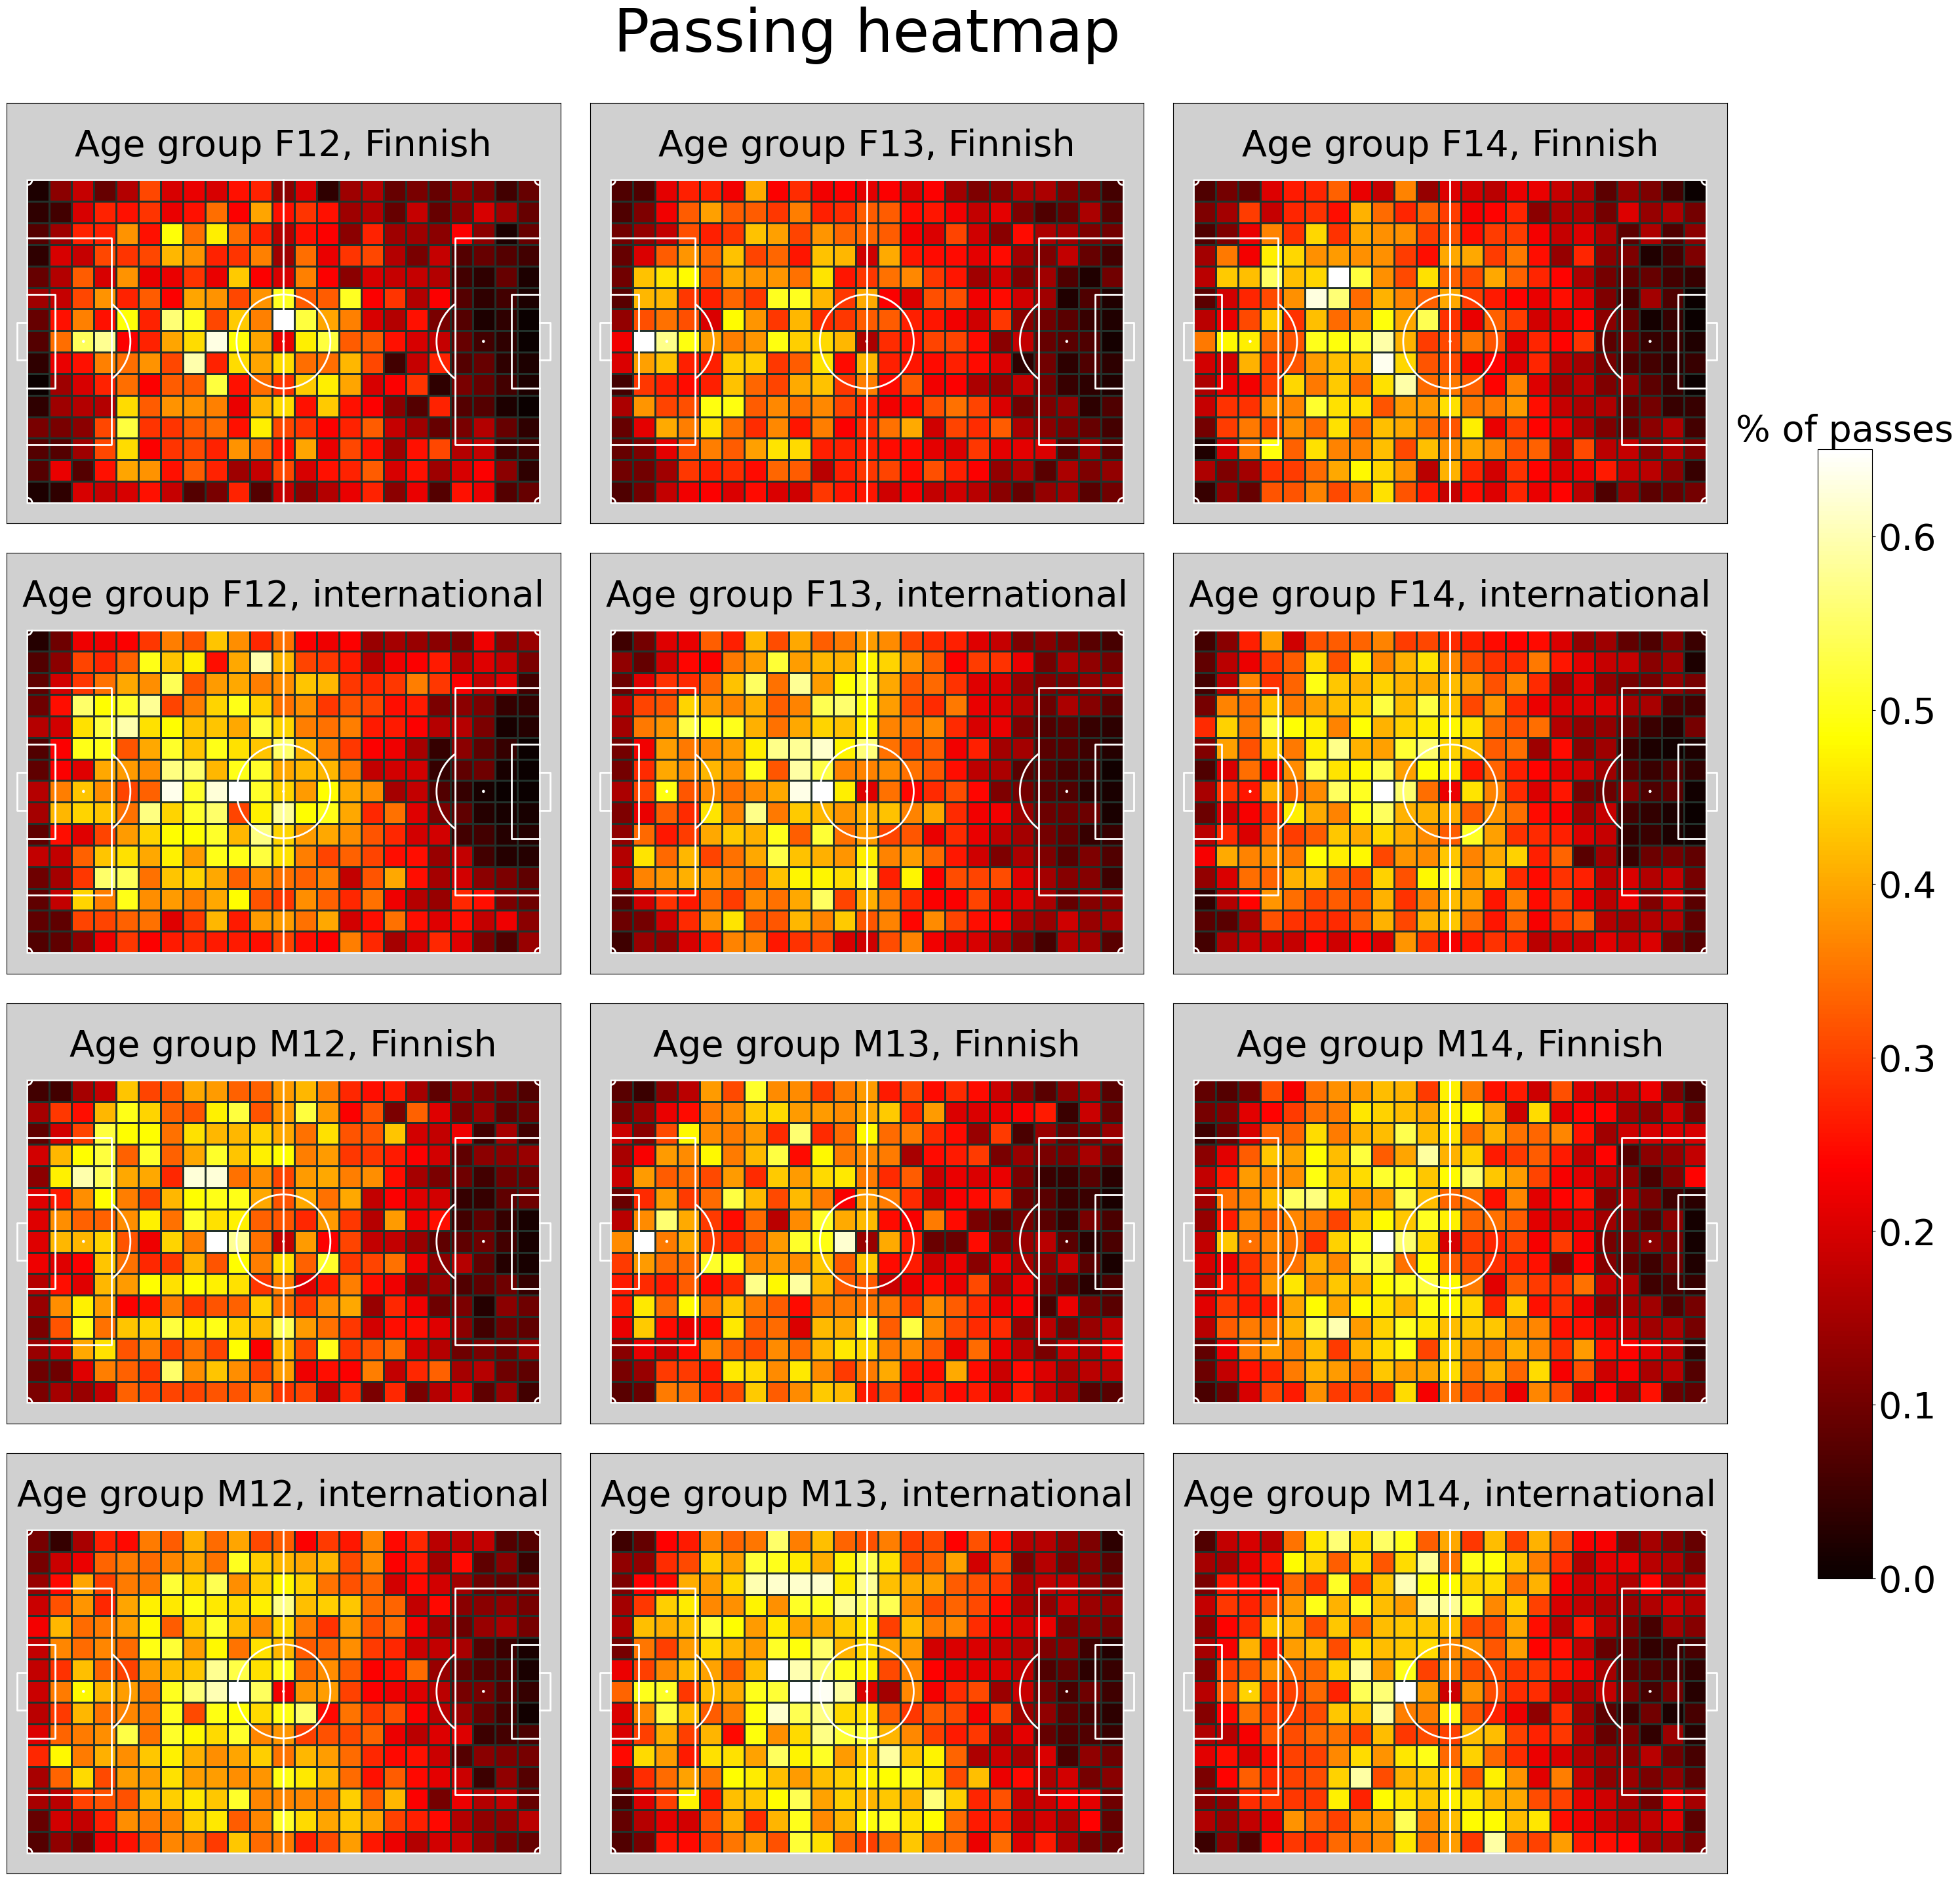

In [14]:
# plot possessional average tempos by age group and team internationality

# age groups
ages = df_passes.groupby('age')

pitch = create_pitch(15)
fig, axes = pitch.grid(nrows=4, ncols=3, figheight=30, axis=False,
                       title_height=0.008, title_space=0.03, grid_height=0.9,
                       endnote_height=0, endnote_space=0)

pitch_axes = axes['pitch'].flat

# init positional variable names
pos_vars = ['start_position_x', 'end_position_x', 'start_position_y', 'end_position_y']

ax_title_font_size = 40
sup_title_font_size = 65

for i, (age, age_df) in enumerate(ages):

    int_levels = age_df.groupby('int_level')

    # axes indexing
    if i > 2:
        i += 3

    for int_val, int_level_df in int_levels:
        title = f"Age group {age}, {['Finnish', 'international'][int_val]}"
        pitch_axes[i].text(0, 38, title, ha='center', va='center', fontsize=ax_title_font_size)
        # invert away passes to also attack to the right
        int_level_df.loc[int_level_df['team'] == 'Away', pos_vars] = int_level_df.loc[int_level_df['team'] == 'Away', pos_vars]*(-1)
        bin_statistic = pitch.bin_statistic(int_level_df.start_position_x, int_level_df.start_position_y, statistic='count', bins=(23, 15))
        bin_statistic['statistic'] = (bin_statistic['statistic'] / np.nansum(bin_statistic['statistic'])) * 100 # normalize
        pcm = pitch.heatmap(bin_statistic, ax=pitch_axes[i], cmap='hot', edgecolors='#22312b', norm='linear', vmin=0, vmax = np.nanmax(bin_statistic['statistic']))
        
        i += 3
    
# Add the colorbar and format off-white
# add cbar axes
cbar_bottom = axes['pitch'][-1, 0].get_position().y0 + 0.15
cbar_left = axes['pitch'][0, -1].get_position().x1 + 0.05
ax_cbar = fig.add_axes((cbar_left, cbar_bottom, 0.03,
                        # take a little bit off the height because of padding
                        0.91 - 0.336))
cbar = plt.colorbar(pcm, cax=ax_cbar)
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(ax_title_font_size)
ax_cbar.set_title("% of passes", fontsize=ax_title_font_size)
fig.suptitle('Passing heatmap', fontsize=sup_title_font_size)
plt.show()

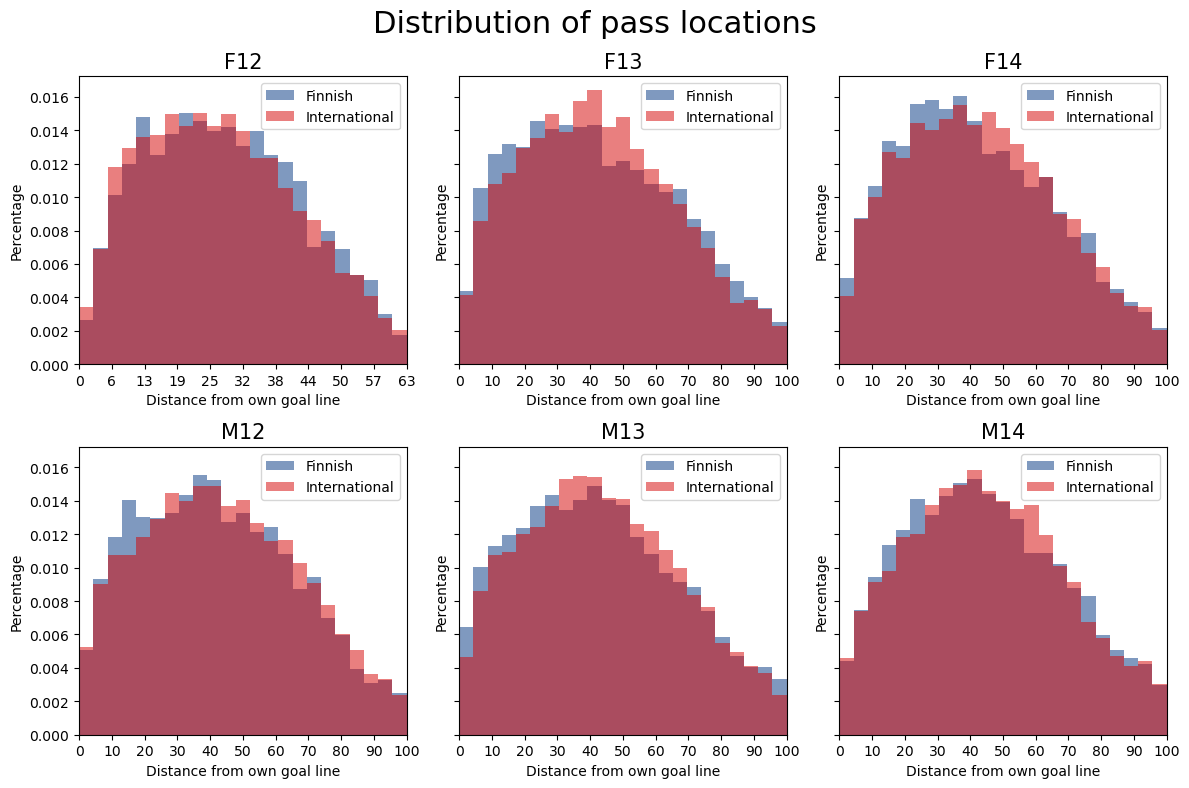

In [15]:
# plot one dimensional pass distribution of all age groups
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

# pitch lengths
pitch_lengths = {'F12': 63, 'F13': 100, 'F14': 100, 'M12': 100, 'M13': 100, 'M14': 100}

# x-tick formatter
def set_pitch_xticks(ax, age):
    if age == "F12":
        # Define ticks in normalized scale (e.g., every 10 on 0–100 scale)
        norm_ticks = np.arange(0, 105, 10)
        # Rescale to original 63m pitch
        original_ticks = (norm_ticks / 100) * 63
        ax.set_xticks(norm_ticks)
        ax.set_xticklabels([f"{int(round(x))}" for x in original_ticks])
        ax.set_xlim(0, max(norm_ticks))
    else:
        xticks = np.arange(0, 105, 10)
        ax.set_xticks(xticks)
        ax.set_xticklabels([str(x) for x in xticks])
        ax.set_xlim(0, max(xticks))

num_bins = 23

# initialize list to store the values for statistical tetsing
x_vals_list = []

for i, (age, age_df) in enumerate(df_passes.groupby('age')):
    ax = axes[i]
    bins = np.linspace(0, 100, num_bins + 1)

    for int_val, int_level_df in age_df.groupby('int_level'):
        x_vals = int_level_df['start_position_x'].copy()
        # Flip for away team
        x_vals[int_level_df['team'] == 'Away'] *= -1

        # Shift to 0–pitch_length if values are negative
        x_vals = x_vals + 100 / 2 if x_vals.min() < 0 else x_vals

        # store values
        x_vals_list.append(x_vals)

        ax.hist(x_vals, bins=bins, density=True, weights=np.ones_like(x_vals) * 100 / len(x_vals),
                alpha=0.5, label=['Finnish', 'International'][int_val], color=colors[int_val])

    ax.set_xlabel('Distance from own goal line', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{age}', fontsize=15)
    set_pitch_xticks(ax, age)
    ax.legend()

plt.suptitle("Distribution of pass locations", fontsize=22)
plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import ks_2samp 

# kolmogorov-smirnov test for each age group from x_vals_list

# ages

ages = ['F12', 'F13', 'F14', 'M12', 'M13', 'M14']
for i in range(6):

    print(f"Age group: {ages[i]}")
    i *= 2
    pass_x_dom = x_vals_list[i]
    pass_x_int = x_vals_list[i+1]
    ks_stat, p = ks_2samp(pass_x_dom, pass_x_int)
    print(f"The means of pass x coordinate of Finnish and international teams\n\
          Dom: {pass_x_dom.mean()}, Int: {pass_x_int.mean()}\n")
    print(f"Kolmogorov-Smirnov Test p-value = {p}\n")

Age group: F12
The means of pass x coordinate of Finnish and international teams
          Dom: 44.556961405814924, Int: 43.29957830637976

Kolmogorov-Smirnov Test p-value = 0.013976850688124797

Age group: F13
The means of pass x coordinate of Finnish and international teams
          Dom: 42.751611744049946, Int: 43.067467653203344

Kolmogorov-Smirnov Test p-value = 0.0002739942323273349

Age group: F14
The means of pass x coordinate of Finnish and international teams
          Dom: 42.09268084310302, Int: 43.13049164262585

Kolmogorov-Smirnov Test p-value = 2.0342969576901828e-05

Age group: M12
The means of pass x coordinate of Finnish and international teams
          Dom: 42.56070342278204, Int: 43.77947357516885

Kolmogorov-Smirnov Test p-value = 0.0013344042108684665

Age group: M13
The means of pass x coordinate of Finnish and international teams
          Dom: 43.110405122494434, Int: 43.8535814118929

Kolmogorov-Smirnov Test p-value = 0.0003858496048486587

Age group: M14
Th

In [17]:
# pitch dimensions of age groups
matches = pd.read_csv('../data/match_info.csv')
dimensions = pd.read_csv('../data/pitch_dimensions.csv')

matches = matches.drop(columns=['home_team_int', 'away_team_int', 'int_level'])

comb = matches.merge(dimensions, on='match_id', how='inner')

comb[['age', 'pitch_length', 'pitch_width']].value_counts().reset_index(name='count')

,age,pitch_length,pitch_width,count
0,M14,100,63,87
1,M12,100,63,82
2,F14,100,63,74
3,F13,100,63,68
4,M13,100,63,65
5,F12,63,40,54
